In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [ ]:


DATASET_PATH = "industry_machine_data.csv"  

try:
    df = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    raise FileNotFoundError(
        f"Arquivo '{DATASET_PATH}' não encontrado. "
        "Coloque o CSV na mesma pasta ou ajuste DATASET_PATH."
    )

print("Dimensão:", df.shape)
df.head()


Dimensão: (4999, 20)


,date,product_id,sales_units,holiday_season,promotion_applied,competitor_price_index,economic_index,weather_impact,price,discount_percentage,sales_revenue,region_Europe,region_North America,store_type_Retail,store_type_Wholesale,category_Cabinets,category_Chairs,category_Sofas,category_Tables,future_demand
0,2023-01-01,151,99,0,0,0.983893,1.314333,0,126.932922,0.000000,12566.359326,False,False,True,False,False,True,False,False,95.0
1,2023-01-02,192,95,1,0,0.977615,1.439582,0,151.355405,0.000000,14378.763512,False,True,False,False,True,False,False,False,101.0
2,2023-01-03,114,101,0,0,0.983913,1.094795,0,191.701693,0.000000,19361.870952,False,False,False,True,True,False,False,False,33.0
3,2023-01-04,171,33,0,0,1.191956,0.907672,0,173.106487,0.000000,5712.514059,False,False,False,True,False,True,False,False,82.0
4,2023-01-05,160,82,0,1,0.855711,1.479690,0,138.587491,10.995213,10114.659145,True,False,False,False,False,False,True,False,13.0


In [ ]:


print("Valores ausentes por coluna:")
print(df.isna().sum())


num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.median()))


df.dropna(inplace=True)

print("\nApós tratamento, dimensão:", df.shape)


Valores ausentes por coluna:
date                      0
product_id                0
sales_units               0
holiday_season            0
promotion_applied         0
competitor_price_index    0
economic_index            0
weather_impact            0
price                     0
discount_percentage       0
sales_revenue             0
region_Europe             0
region_North America      0
store_type_Retail         0
store_type_Wholesale      0
category_Cabinets         0
category_Chairs           0
category_Sofas            0
category_Tables           0
future_demand             0
dtype: int64

Após tratamento, dimensão: (4999, 20)


In [ ]:


if "future_demand" not in df.columns or "sales_units" not in df.columns:
    raise KeyError("Certifique-se de que 'future_demand' e 'sales_units' existam no CSV.")

threshold = df["sales_units"].median()
df["High_Demand"] = (df["future_demand"] > threshold).astype(int)
df["High_Demand"].value_counts()


High_Demand
0    2501
1    2498
Name: count, dtype: int64

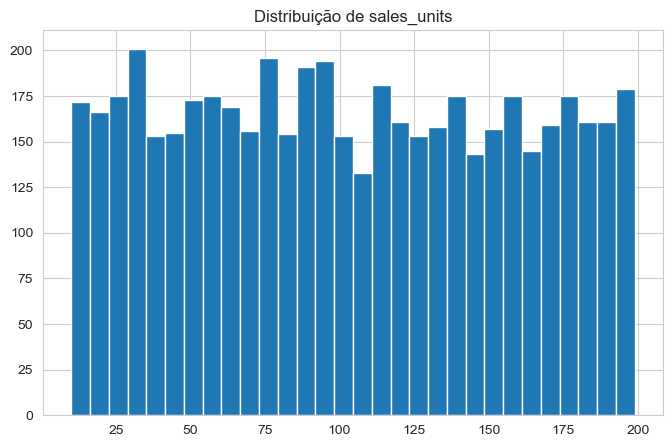

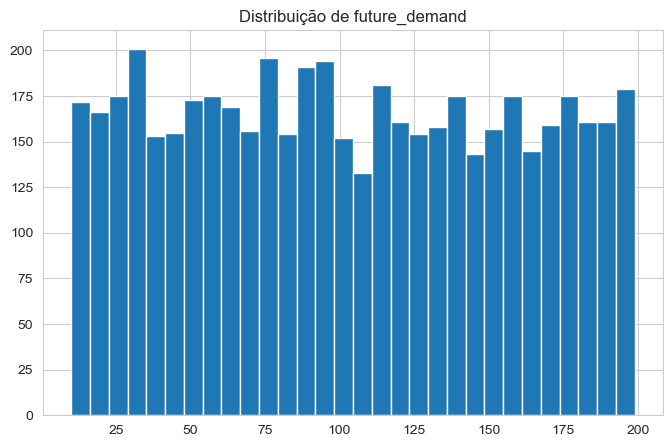

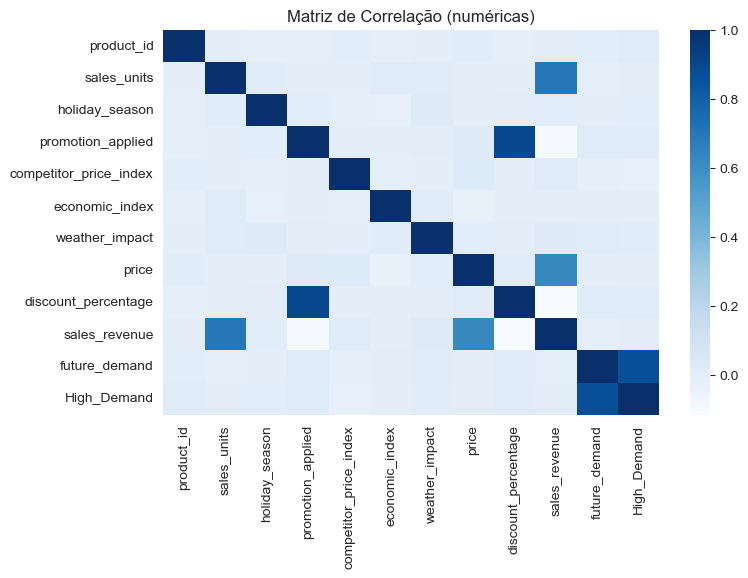

In [ ]:



df["sales_units"].hist(bins=30)
plt.title("Distribuição de sales_units")
plt.show()

df["future_demand"].hist(bins=30)
plt.title("Distribuição de future_demand")
plt.show()


corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=False, cmap="Blues")
plt.title("Matriz de Correlação (numéricas)")
plt.show()


In [ ]:

df.rename(columns={'region_North America': 'region_North_America'}, inplace=True)



if "High_Demand" not in df.columns:
    threshold = df["sales_units"].median()
    df["High_Demand"] = (df["future_demand"] > threshold).astype(int)

df_model = pd.get_dummies(df, drop_first=True)



X = df_model.drop(columns=["High_Demand"])
y = df_model["High_Demand"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:


nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("=== Naive Bayes ===")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, zero_division=0))



=== Naive Bayes ===
[[  0 500]
 [  0 500]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



=== Random Forest ===
[[500   0]
 [  0 500]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



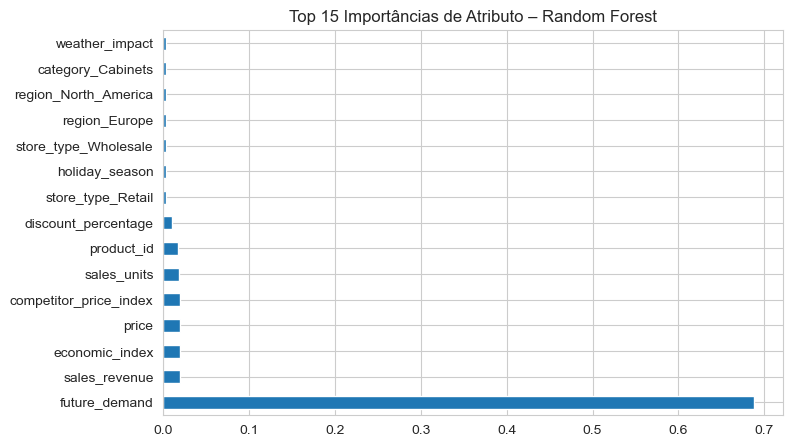

In [ ]:


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Importância das features
importances = pd.Series(rf.feature_importances_, index=df_model.drop(columns=["High_Demand"]).columns)
importances.nlargest(15).plot(kind="barh")
plt.title("Top 15 Importâncias de Atributo – Random Forest")
plt.show()
